# Goals
Here, we will plot the correlational structure and number of DEGs for single ligand treatment conditions.

# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42
mpl.rcParams['text.usetex']  = False

In [2]:
degSingle = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_single_term/glmGamPoi_singleTerm_lfc_0.1filter.csv")
coeffSingle = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_single_term/glmGamPoi_coefficients_0.1filter.csv")

# Plot Correlational Heatmaps
We will correlate different single ligand treatment condtions using the coefficients generated from our single term GLM model (no modeling of interaction effects). We will select the top 2000 variable genes among significant differentially expressed genes.

In [33]:
# helper function to plot heatmap
def plot_heatmap(corr_matrix,
                      title='Heatmap', xlabel='Pearson\ncorr', cmap='magma',
                      method='ward', width=12, height=10,
                      xticklabels=True, yticklabels=True):
    """
    Plots a customizable heatmap with clustering and annotations.

    Parameters:
        corr_matrix (DataFrame): The data for the heatmap (correlation matrix).
        anno (DataFrame): DataFrame of annotations for rows.
        legend_handles (list): Handles for the legend.
        title (str): Title of the heatmap.
        cmap (str): Colormap for the heatmap.
        method (str): Clustering method (e.g., 'ward', 'average').
        vmax (float): Maximum value for the color scale.
    """
    g = sns.clustermap(
        corr_matrix, 
        annot=False, 
        cmap=cmap,
        method=method,
        center=0,
        dendrogram_ratio=(.1, 0),  # Adjusts the width of the dendrogram
        xticklabels=xticklabels,  # Ensures all x-axis labels are shown
        yticklabels=yticklabels,  # Ensures all y-axis labels are shown
        cbar_kws={
            'orientation': 'vertical',  # Vertical colorbar
            'shrink': 0.5,  # Shrink the colorbar size
        },
        figsize=(width, height)
    )

    # Adjust the colorbar and tick labels
    g.cax.set_position([1.03, 0.5, .03, .2])  # [x, y, width, height] for the colorbar position
    g.cax.set_xlabel(xlabel, fontsize=10)  # Set horizontal label
    g.cax.xaxis.set_label_position('top')  # Position the label below the colorbar
    
    # Customize labels and title
    g.ax_heatmap.set_xlabel("")
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
    g.ax_heatmap.set_title(title, fontsize=20)

    plt.show()
    return g

In [28]:
# select top n genes based on variance in singificant single ligand lfc values
degSingle_linker = degSingle[degSingle['condition'].str.contains('linker', case=False, na=False)]
genes_selected = (
    degSingle_linker
    .query('adj_pval < 0.01')
    .groupby('name')['lfc']
    .var()
    .nlargest(2000)
    .index.tolist()
)

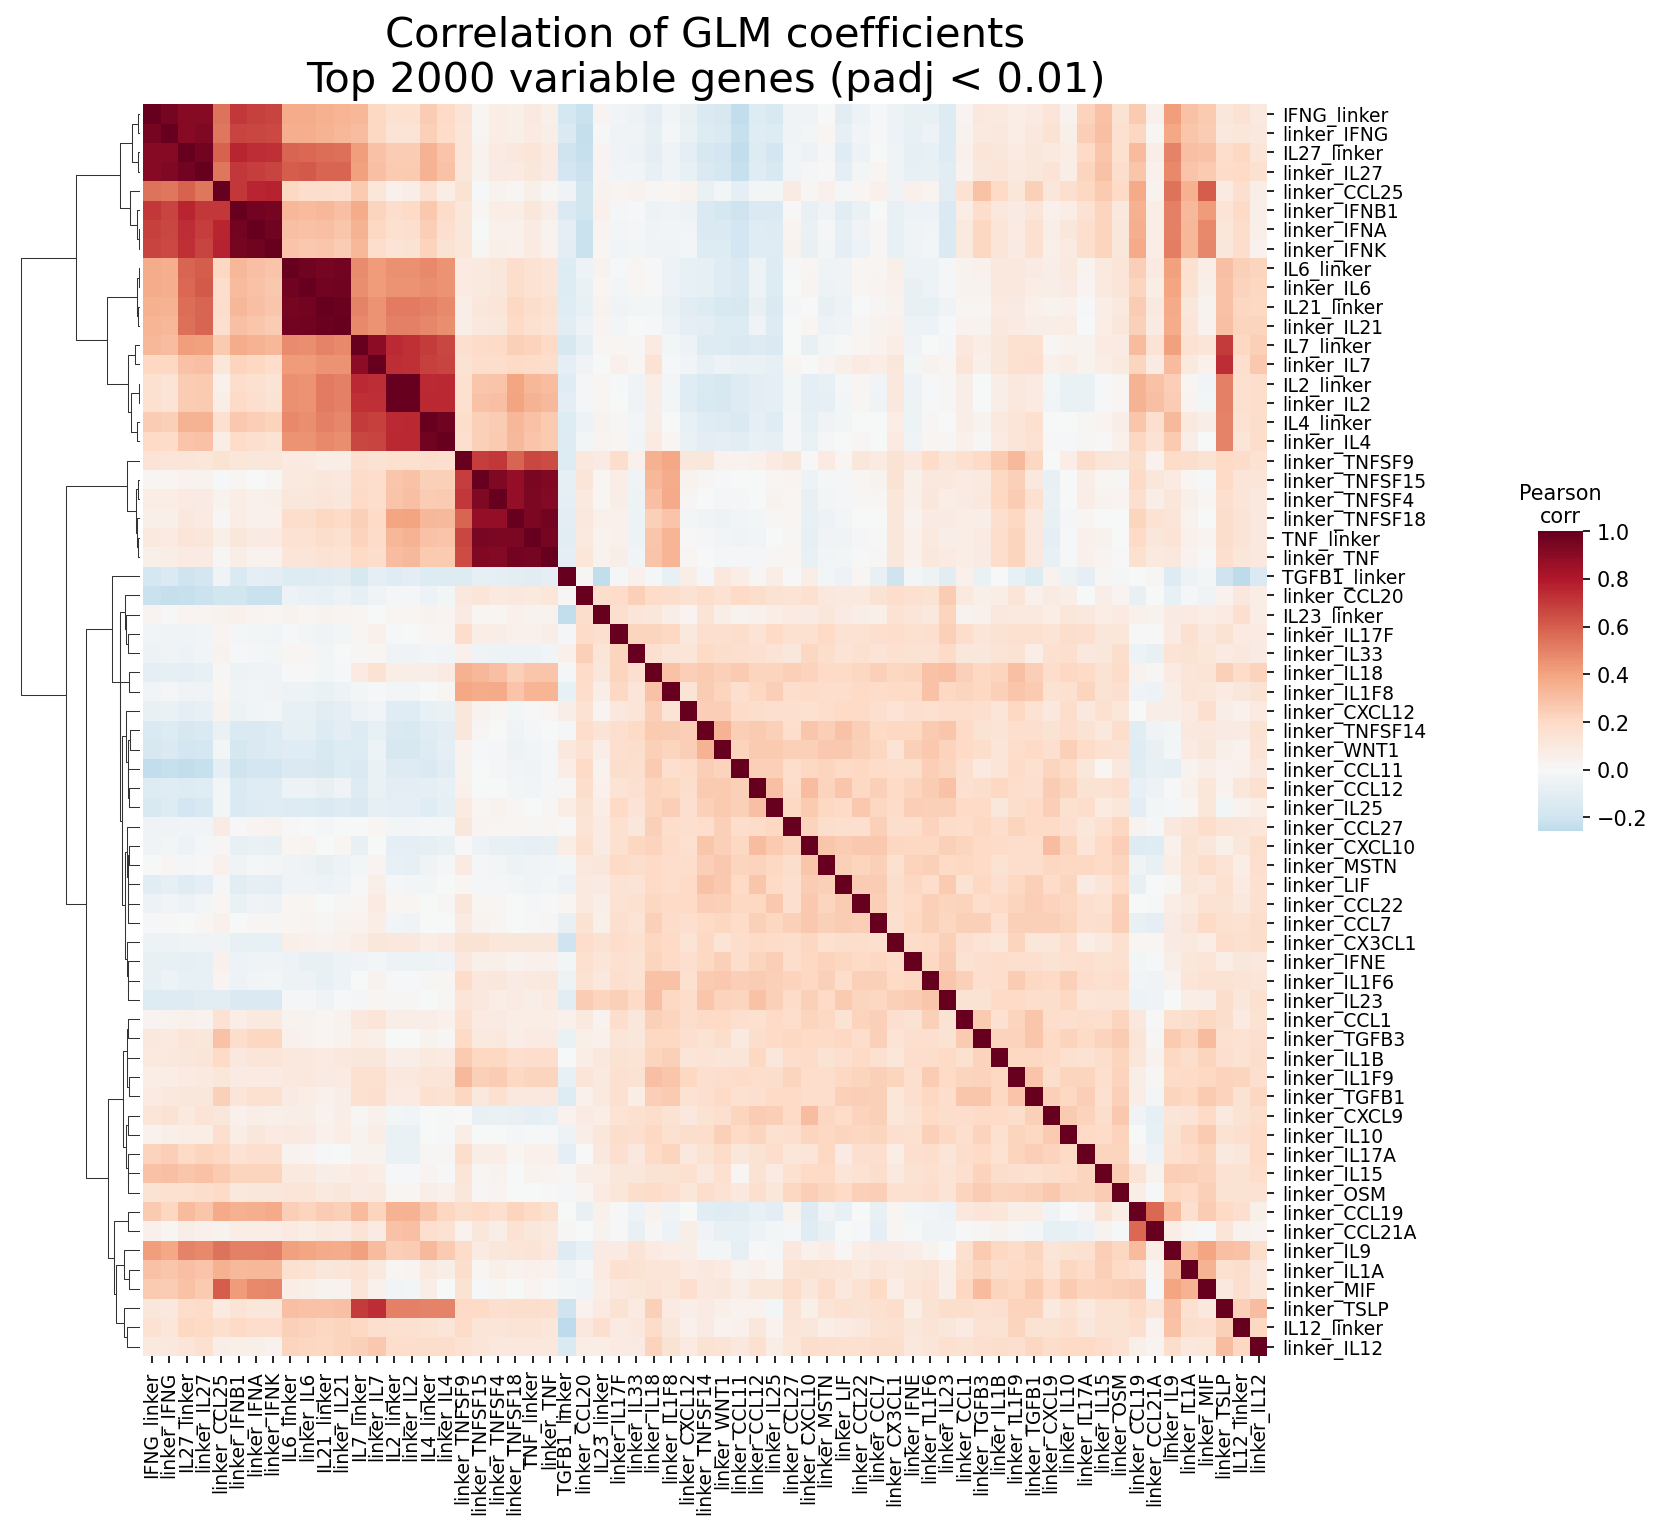

In [34]:
# Build the correlation matrix
wide_mat = (
    coeffSingle
    .loc[coeffSingle['name'].isin(genes_selected) & coeffSingle['condition'].str.contains('linker', case=False, na=False)]
    .pivot_table(
        index='name',
        columns='condition',
        values='ligand',
        fill_value=0
    )
)
corr_mat = wide_mat.corr(method='pearson')

plt_obj = plot_heatmap(
    corr_matrix=corr_mat,
    title='Correlation of GLM coefficients\nTop 2000 variable genes (padj < 0.01)',
    cmap='RdBu_r',
    method='ward',
    width=10,
    height=10
)
plt_obj.savefig("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/plots/linkerOnly_coeff_heatmap.pdf", bbox_inches="tight")

# Plot DEG Numbers

In [37]:
linker_conditions = (degSingle
    .query('adj_pval < 0.01')
    [degSingle['condition'].str.contains('linker')]
    .groupby('condition')
    .size()
    .sort_values(ascending=False)
    .reset_index(name = "n_degs")
)

/tmp/ipykernel_1652885/2517676947.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  linker_conditions = (degSingle


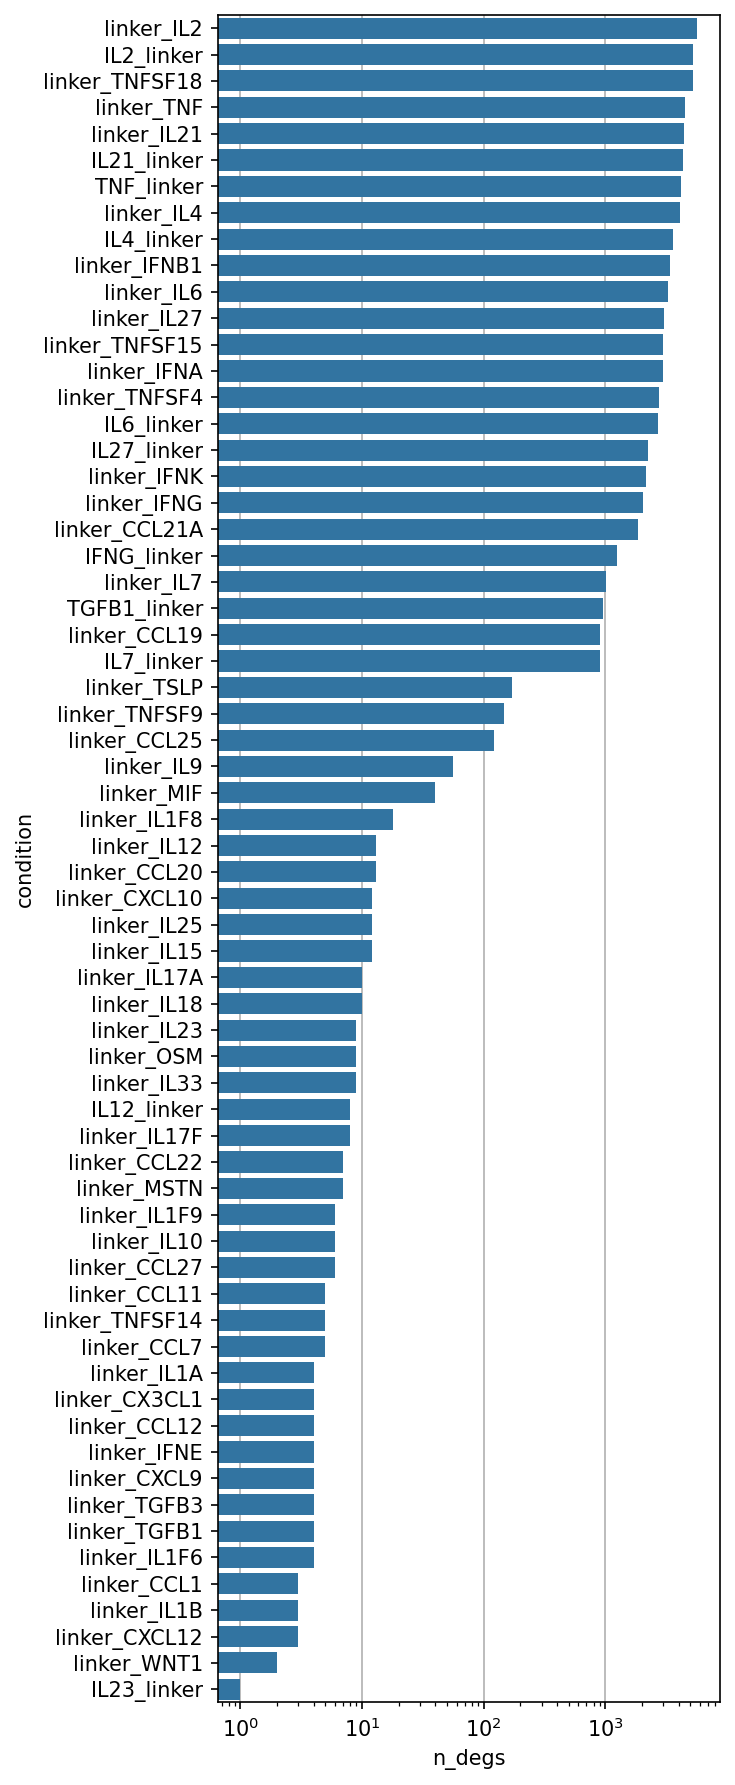

In [45]:
plt.figure(figsize=(5,12))
ax = sns.barplot(
    data=linker_conditions,
    y='condition',
    x='n_degs'
)
ax.set_xscale('log')
ax.grid(True, axis='x')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()
ax.figure.savefig("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/plots/linkerOnly_nDEGs_barplot.pdf", bbox_inches="tight")